In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [281]:
sADF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [282]:
#sADF.head()

In [283]:
#print(sADF.shape,sBDF.shape)

In [284]:
#print(sADF.columns,sBDF.columns)

In [285]:
pd.to_datetime(sADF["Timestamp"]);
pd.to_datetime(sBDF["Timestamp"]);

In [300]:
wl_mm=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
slope_up=[]
slope_dw=[]
for i in range(sADF.shape[0]-4):
    slope_dw.append((wl_mm[i+4]-wl_mm[i])/(4*5))
    slope_up.append((wl_mm[i+1]-wl_mm[i])/(2*5))

(array([1.4000e+01, 5.8000e+01, 6.8900e+02, 3.7641e+04, 3.6400e+02,
        1.1800e+02, 2.7000e+01, 1.2000e+01, 1.4000e+01, 1.0000e+01]),
 array([-26.65, -18.76, -10.87,  -2.98,   4.91,  12.8 ,  20.69,  28.58,
         36.47,  44.36,  52.25]),
 <a list of 10 Patch objects>)

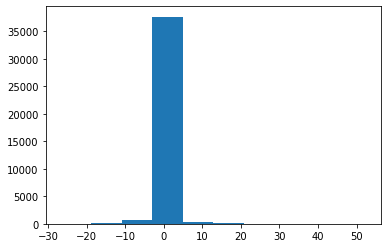

In [301]:
plt.hist(slope_dw)


(array([5.0000e+00, 4.9000e+01, 3.8724e+04, 1.4400e+02, 1.6000e+01,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-32.4 , -19.35,  -6.3 ,   6.75,  19.8 ,  32.85,  45.9 ,  58.95,
         72.  ,  85.05,  98.1 ]),
 <a list of 10 Patch objects>)

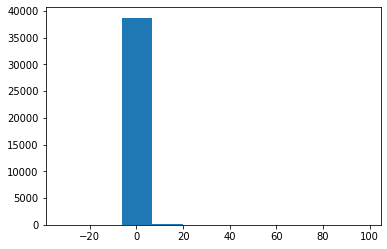

In [302]:
plt.hist(slope_up)

In [298]:
def IdentifyEvents_2(df,tol_up,tol_dw):
    #  This method compare slope for start and end of an event
    # For the start of an event we want the slope to be very big +ve value (steep tangent with +ve slope)
    # To detect the end of an event we want the slope to be very small -ve value (flat tangent with -ve slope)
    wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    for i in range (df.shape[0]-3):
        
        if nre==True:
            rpc=0    # duration of rainfall set to zero
            # calculating the slope (mm/min) at index i
            slope_1=(wl_mm[i+1]-wl_mm[i])/(2*5)   # forwward difference formula
            if slope_1>tol_up:
                # This is a new rainfall event
                # print("A new rainfall started at time :",df["Timestamp"][i]," with index position :",i)
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                dpc=0     # Dry period count initialization
                rpc+=1      # count the duration of rainfall
                nre=False
                # continue
        else:
            # calculating the slope (mm/min) at index i+1
            # slope_2=(wl_mm[i-1]-8*wl_mm[i]+8*wl_mm[i+2]-wl_mm[i+3])/12*5
            slope_2=(wl_mm[i+4]-wl_mm[i])/(4*5)  # average slope of 4 consecutive time steps
            if slope_2>tol_dw: 
                dpc+=1
                skip=2*(5*12)    # 2 hours of no significant change in water level means start of another event
                # save this date 
                if dpc>skip:
                    nre=True
                    end_time.append(df["Timestamp"][i+1-skip])
                    end_index.append(i+1-skip)
                    duration.append(rpc-skip)
                    #print(f"Rainfall event ended at time :",df["Timestamp"][i-72]," with index position :",i-72,"\nDuration of this rainfall period was :",rpc-72)
                    #print("Now it is a dry period of more than 6 hours")
                    #print("***********************************" )
                    # continue
                else:
                    rpc+=1    # count the duration of rainfall
            else:
                dpc=0
                rpc+=1
    return start_time,end_time,start_index,end_index,duration,wlc_mm

In [313]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_level_changeA=IdentifyEvents_2(sADF,6,-0.5)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA
#np.size(start_timeA)

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:30:00 a.m.,2022-02-19 11:50:00 p.m.,1085,1233,147
1,2022-02-21 3:55:00 a.m.,2022-02-21 8:30:00 a.m.,1570,1625,54
2,2022-02-26 5:25:00 p.m.,2022-03-01 1:45:00 a.m.,3172,3848,675
3,2022-03-01 4:25:00 p.m.,2022-03-02 9:05:00 p.m.,4024,4368,343
4,2022-03-11 8:55:00 p.m.,2022-03-12 1:25:00 p.m.,6958,7156,197
5,2022-03-13 7:00:00 a.m.,2022-03-15 8:15:00 p.m.,7355,8090,734
6,2022-03-17 7:00:00 a.m.,2022-03-19 12:00:00 p.m.,8507,9143,635
7,2022-03-20 2:25:00 p.m.,2022-03-21 2:40:00 p.m.,9460,9751,290
8,2022-03-23 9:25:00 a.m.,2022-03-23 5:55:00 p.m.,10264,10366,101
9,2022-03-26 5:05:00 a.m.,2022-03-26 11:00:00 a.m.,11076,11147,70


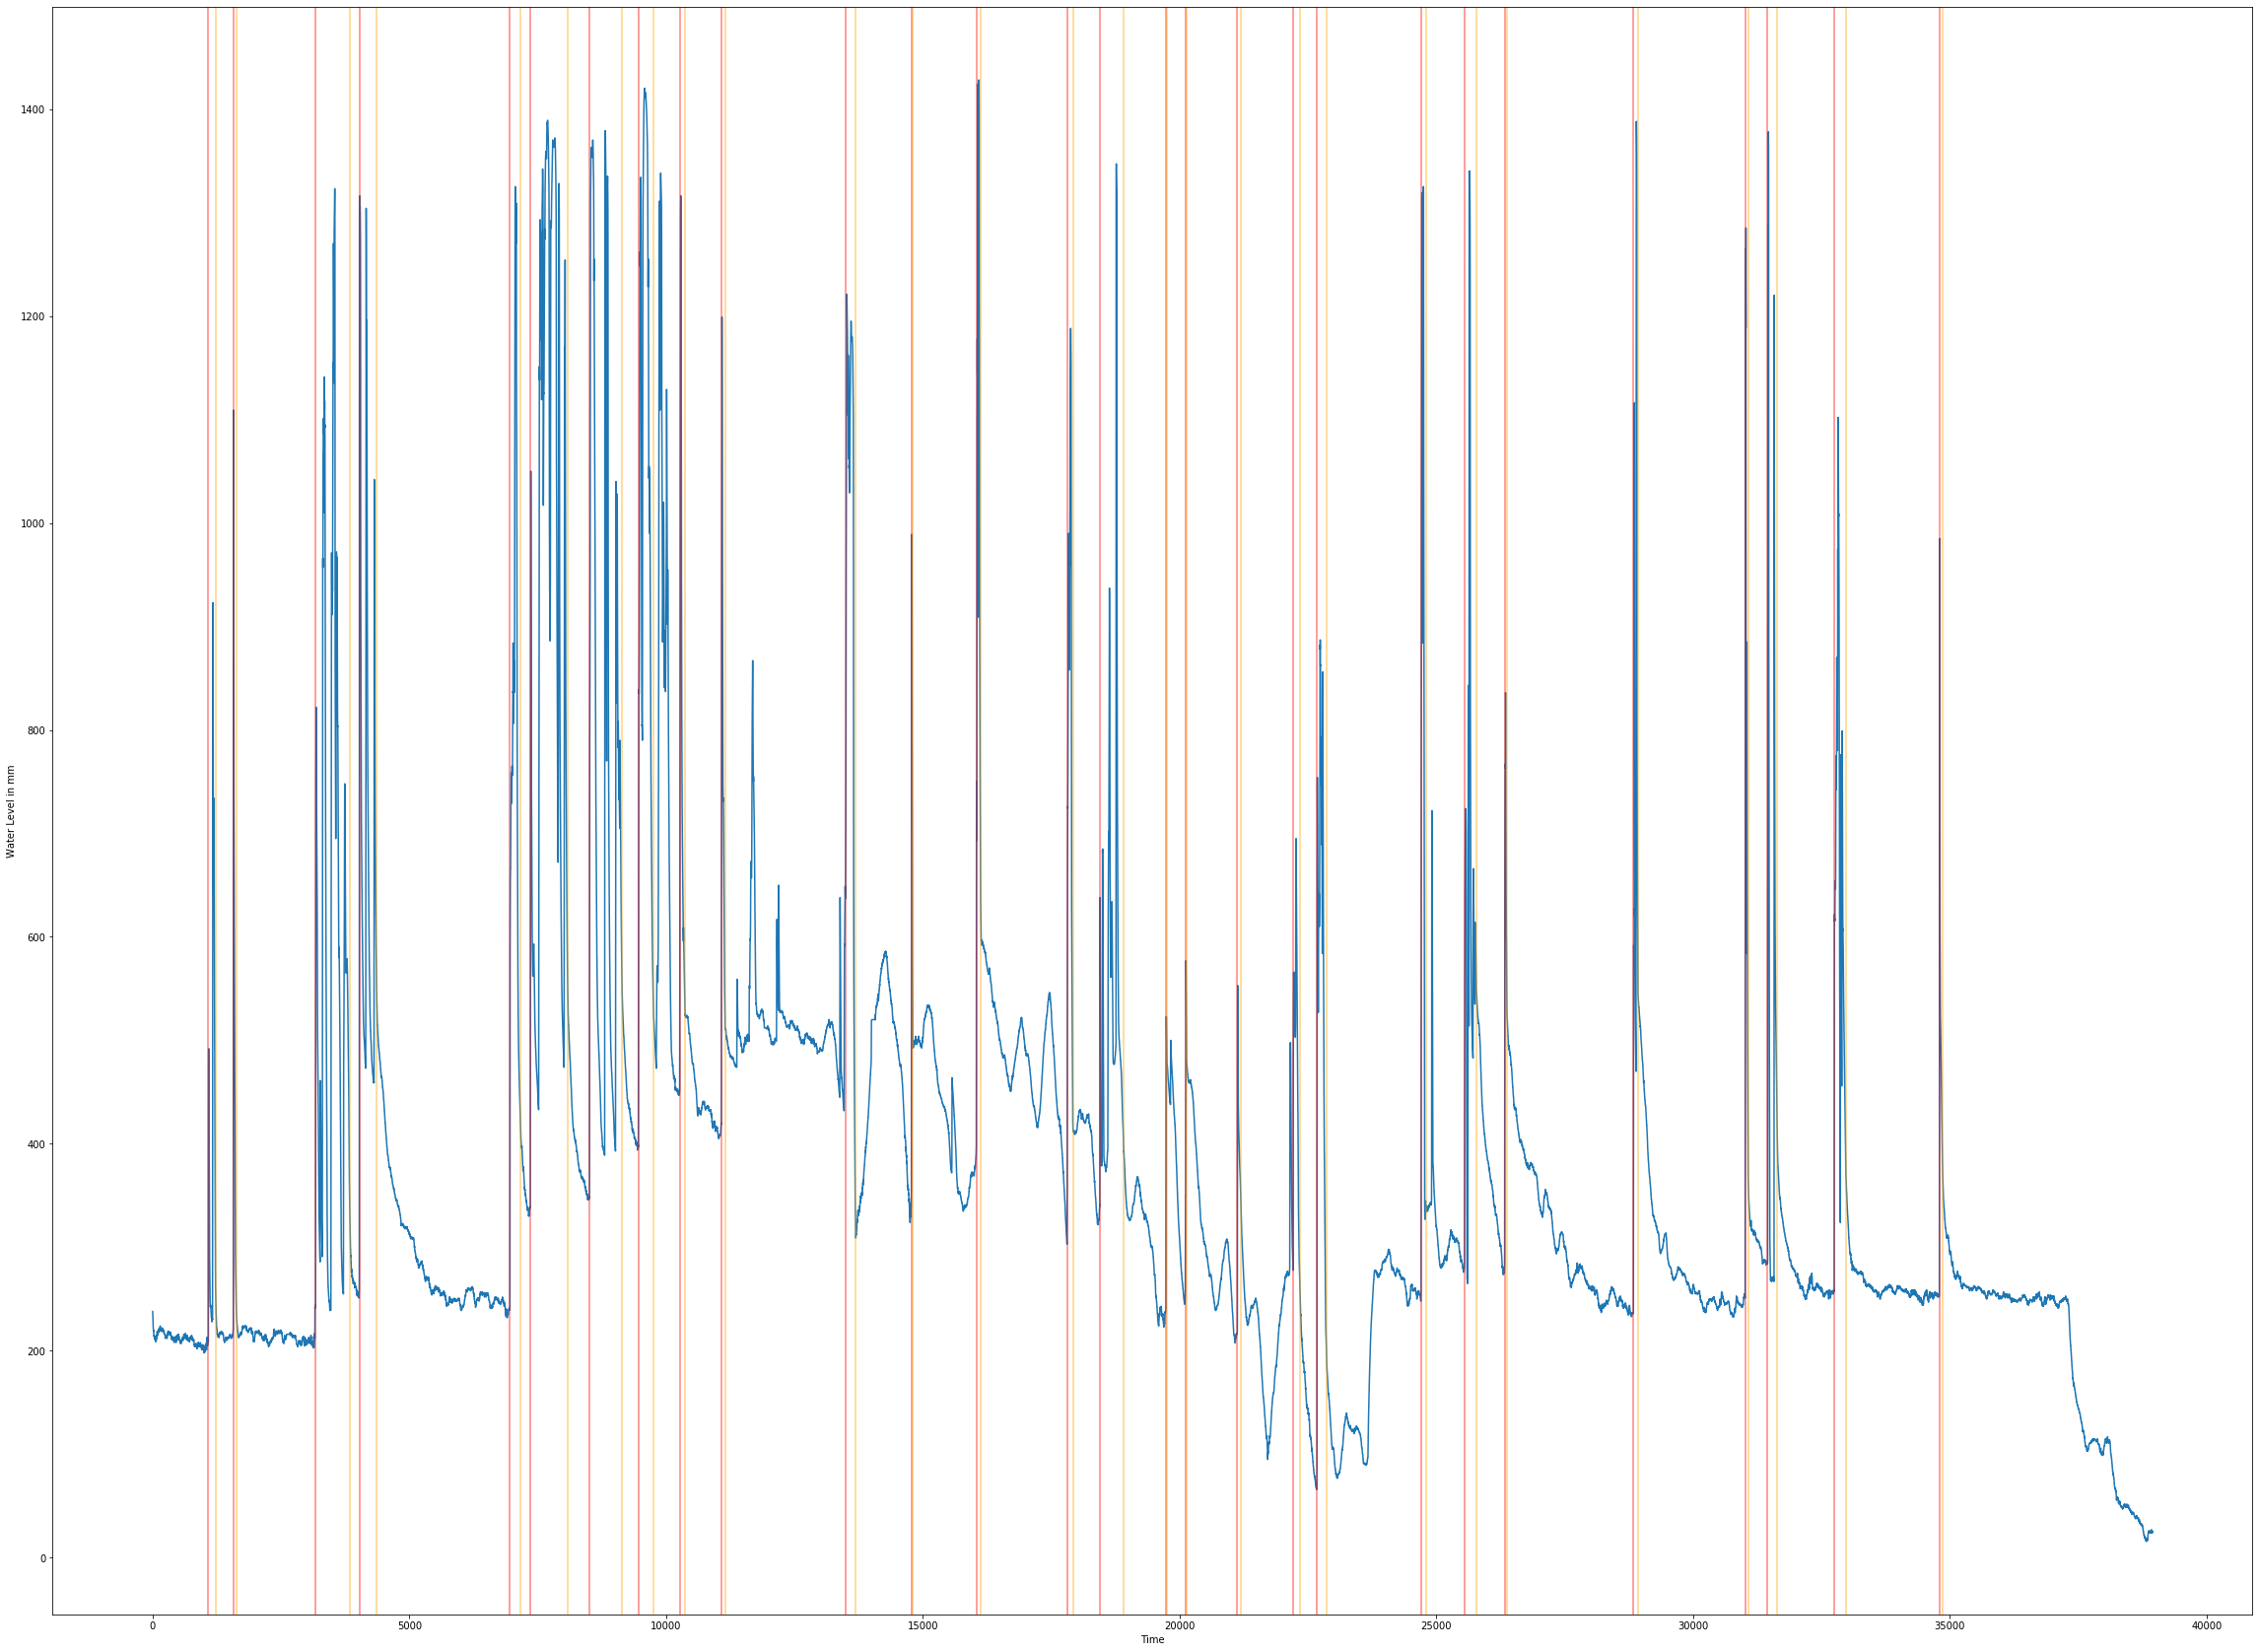

In [314]:
water_level=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
plt.figure(figsize=(40, 30))
plt.plot(water_level)
for i in start_indexA:
    plt.axvline(x=i, alpha=0.5,color='r')
for i in end_indexA:
    plt.axvline(x=i,alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Water Level in mm')
plt.show()

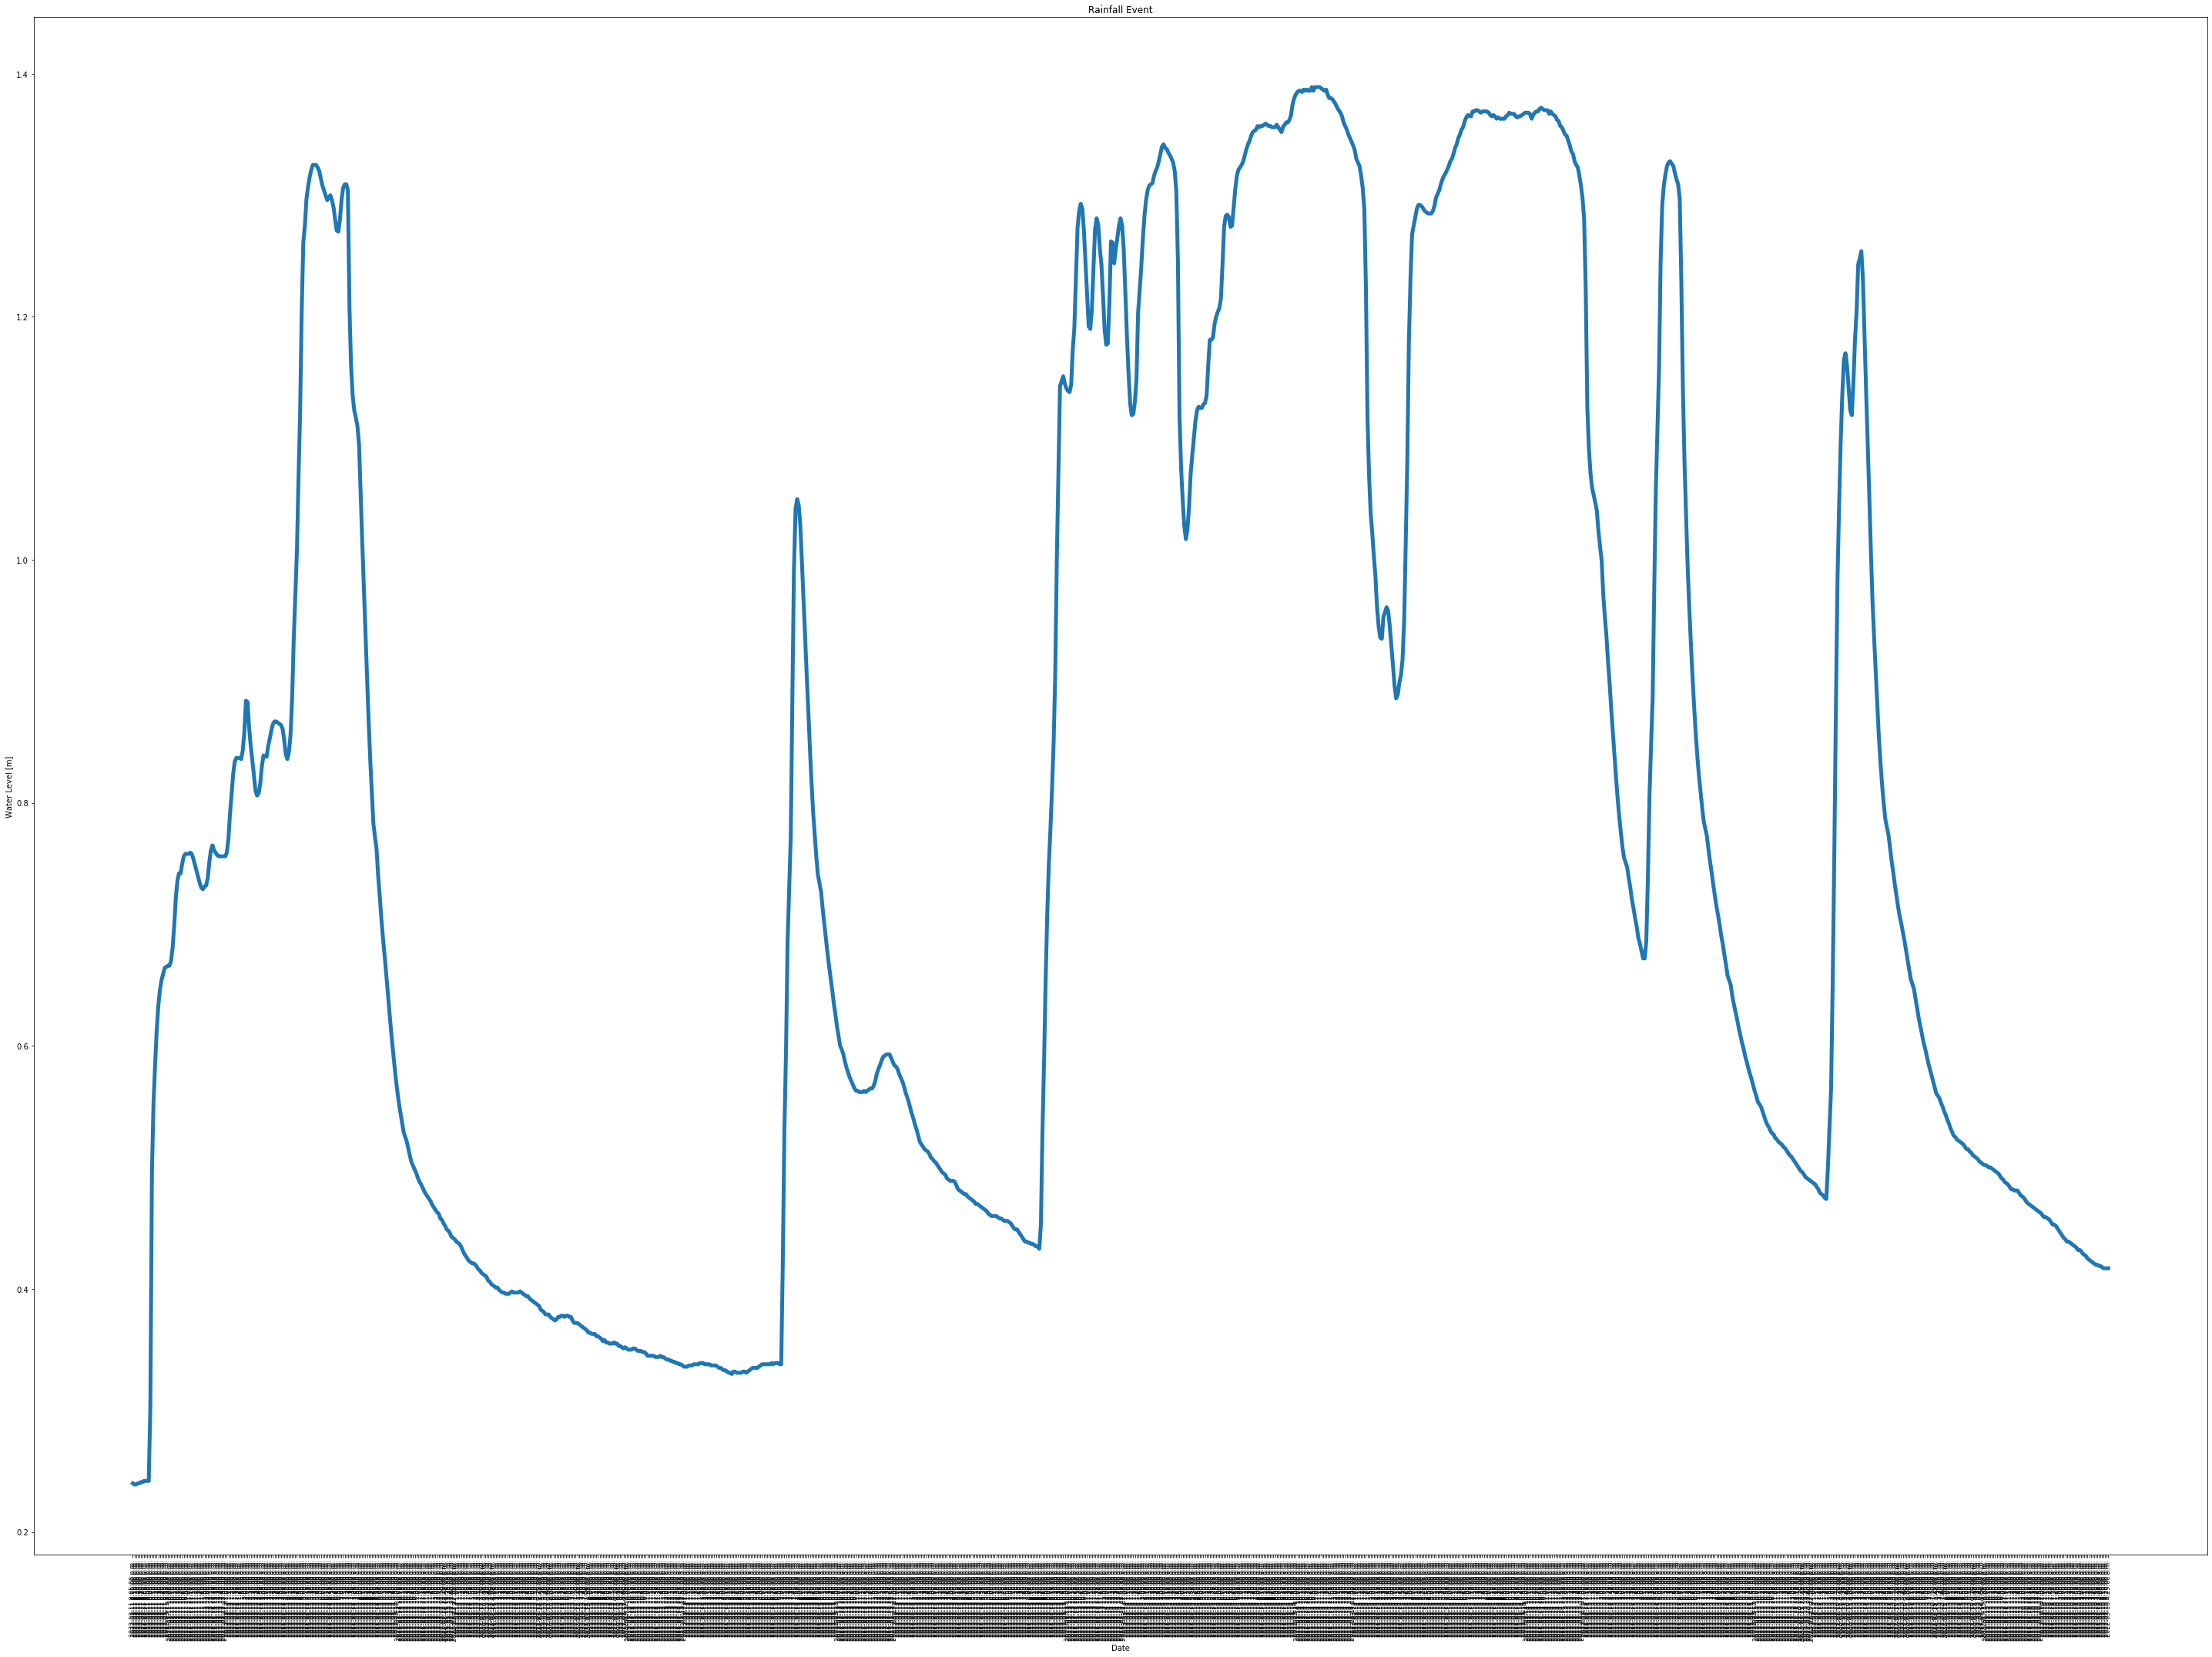

In [266]:
# Let's see a particular !Rainfall event
buffer=10
index=4
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
#plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level in m')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

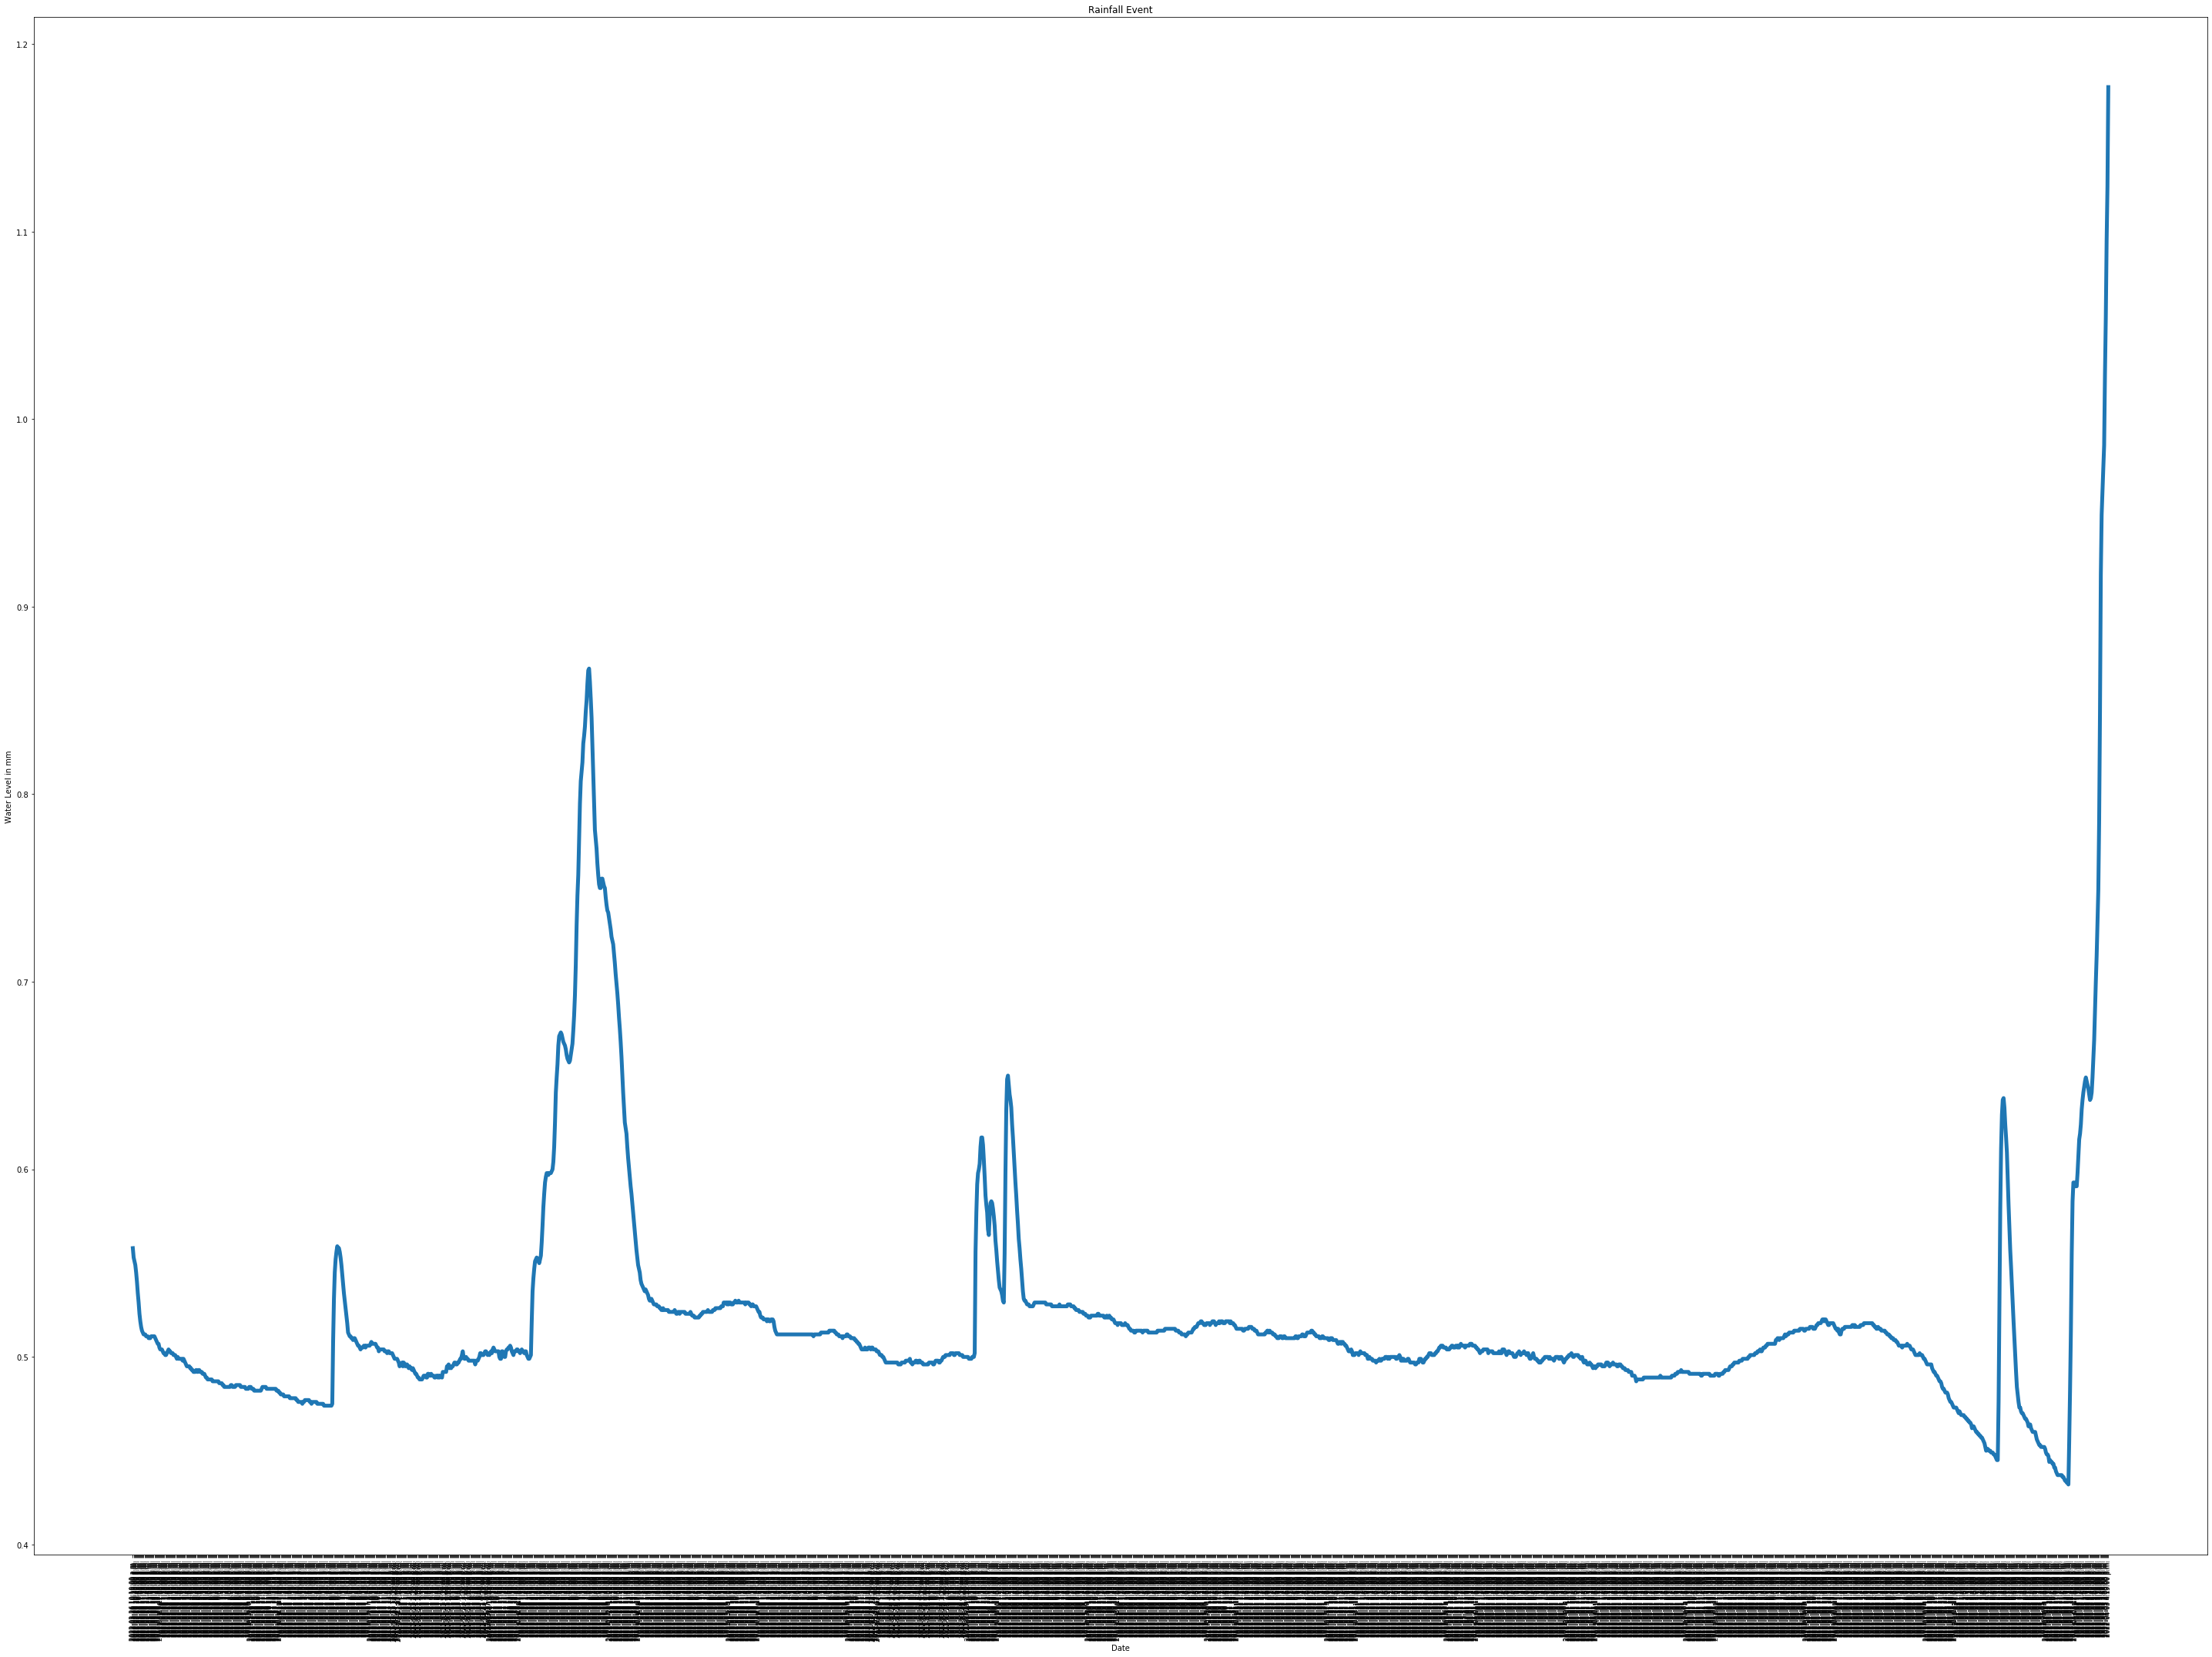

In [316]:
# Let's look at a particular No !Rainfall event
buffer=10
index=10
X=list(sADF.loc[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_end_index"][index-1]-buffer:rf_eventA["Rainfall_start_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
#plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level in m')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()